In [1]:
import pyslha #For interacting with SLHA files
import subprocess #Running command
import scipy #Numeric Library
import sympy #symbolic computation - might not be used here
from scipy import optimize
from sympy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
%matplotlib inline
from numpy import logspace, linspace 
from itertools import product
import glob #filehandling
from subprocess import call
import os
#Path to modified verison of Softsusy 
SoftSUSY_PATH = 'softsusy-4.1.4-Garon/softpoint.x' 
mHiggs = 125 #Higgs Mass for paper
print ("hello")

hello


In [2]:
import os
current_path = os.getcwd()
print(current_path)

/Users/neilleonard/Repos/SoftSuzy/Plotting_Setup


In [2]:
def slhaPoint(model='FGMCaseB0', mMess=1e12, tanBeta=10, beta2=0, beta3=0, betaeps=0, thetavev=0, 
              outputFile='test.slha', Lambda=1e6, mode='Point', LambdaGuess=1e6,particle=25):
    '''
    Code for interacting with SoftSUSY and running the models we've been looking at.
    The models themselves are encoded in a modified version of it. 
    This may seem like extra work because it accepts an arbitrary SLHA2 file, but since our models
    include fitted parameters, like the Yukawa couplings, we need to use the values that it calculates
    during the running. 
    The parameters:
    model - the name of the model in SoftSUSY
    mMess - the messenger scale
    tanBeta - tan beta
    beta2 - beta2
    beta3 - beta3
    outputFile - the name of the file to write to (this step could conceivably be removed by writing the console output to memory)
    Lambda - F/M
    mode - There are 3 modes
        'Fit' - uses Newton's method from a few different starting points
        'Bisect' - uses a Bisection routine from a few different brackets
        'Point' - runs a single point
    LambdaGuess - a guess at the value of Lambda for the 'Fit' mode.
    particle - the pdg code for the particle that we are interested in getting data for
    
    note that current implementation, fit and bisect only work for higgs, could fix, but it could only really work for
    particles with known values
    '''
    
    dataline ="./{} {} --mMess={} --LAMBDA={} --tanBeta={} --beta2={} --beta3={} --thetavev={} --betaeps={} --cgrav=1. > {}"
    startingPoints = [LambdaGuess, 1e6, 5e6, 6e4]
    bracket, l = [(2,5), (5,10), (2,10), (2,8), (4,8), (1,3), (8,12)], 0
    
    #a helper functin that takes a value of x (Lambda), runs it (line 2) and then reads in the Higgs mass
    def f(x):
        string = dataline.format(SoftSUSY_PATH, model, str(mMess), str(x), 
                                 str(tanBeta), str(beta2), str(beta3), str(thetavev), str(betaeps), outputFile)
        subprocess.Popen(string, stdout=None, shell=True).wait()
        #print ("the string is ")
        #print (string)
        return pyslha.read(outputFile).blocks['MASS'][particle]
    
    if mode == 'Fit':
        #print ('in fit')
        a, i = 0, 0
        while((a <= 0) & (i < len(startingPoints))):
            try:
                #Newton's method
                print ("in try")
                a = optimize.newton(f, startingPoints[i], tol=1e-4)
                print ("in newton")
                print (a)
            except:
                print ('got excepted')
                a = 0
                i += 1
        if (a>0):
            data = pyslha.read(outputFile)
            #accept or reject based on the deviation from the Higgs mass
            if (-0.1 < data.blocks['MASS'][25]-125 < 0.1) :
                try:
                    #if there's something in this location SoftSUSY has an error.
                    data.blocks['SPINFO'][3]
                except:
                    return data
    elif mode == 'Bisect':
        for k in bracket:
            print(k)
            try:
                l = optimize.brentq(f, k[0] * 1e5, k[1] * 1e5, rtol=1e-4)
                if l:
                    break
            except:
                #print('nada')
                continue
        if l:
            data = pyslha.read(outputFile)
            print(data.blocks['MASS'][25])
            if (-0.25 < data.blocks['MASS'][25]-125 < 0.25) :
                try:
                    data.blocks['SPINFO'][3]
                except:
                    return data
            else:
                #the bisection routine tends to get things close but not exact, so it calls 'Fit' if it's close.
                return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit', LambdaGuess=data.blocks['MINPAR'][1])
        else:
            #just to be safe (but is probably unneded)
            return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit')
    else:
        #runs a single point
        try:
            f(Lambda)
            data = pyslha.read(outputFile)
            return data.blocks['MASS'][particle], data
        except (pyslha.ParseError, RuntimeError):
            return "No Solution", 0

In [6]:
gd = slhaPoint(model='FGMCaseB2',outputFile="break2.slha",beta2=0,beta3=0,tanBeta=30,mMess=1e10)

In [16]:
gd[1].blocks['MASS'][25]

NameError: name 'gd' is not defined

In [15]:
gridBeta2 = linspace(0.0,1.0,41)
gridBeta3 = linspace(0.0,1.0,41)
print(gridBeta3)

resultsFGMCaseB2 = {}
k = 0
for j in product(gridBeta2, gridBeta3):
    k+=1
    print(k)
    resultsFGMCaseB2[j] = slhaPoint(model='FGMCaseB2',beta2= j[0], beta3= j[1])
    if(j[0]==j[1]==0):
        print("printingout the higgs")
        print(resultsFGMCaseB2[j][1].blocks['MASS'][25])
        print("above is the higgs mass")
print("done")    

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]
1
printingout the higgs
126.637685
above is the higgs mass
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


plotData is
zm, then zn, then z0
[[126.637685 126.637638 126.637583 ... 126.632029 126.631772 126.631518]
 [126.637686 126.637624 126.637585 ... 126.632031 126.631787 126.63151 ]
 [126.637683 126.637639 126.63758  ... 126.63204  126.631787 126.631504]
 ...
 [126.637641 126.637605 126.637552 ... 126.632002 126.631737 126.631489]
 [126.637642 126.637598 126.637549 ... 126.632001 126.631737 126.631478]
 [126.637644 126.637599 126.637532 ... 126.631994 126.631734 126.631474]]
zn
[[11845.9121 11845.8912 11845.8265 ... 11814.7433 11813.0874 11811.3902]
 [11845.9072 11845.8844 11845.8218 ... 11814.7381 11813.0839 11811.3839]
 [11845.8916 11845.8709 11845.8059 ... 11814.7228 11813.0676 11811.367 ]
 ...
 [11838.5826 11838.5627 11838.4977 ... 11807.018  11805.3389 11803.6194]
 [11838.1939 11838.173  11838.1083 ... 11806.6079 11804.928  11803.2057]
 [11837.7953 11837.7743 11837.7073 ... 11806.1869 11804.5062 11802.7831]]
z0
[[6076.06245 6076.05662 6076.05503 ... 6075.04025 6074.9975  6074.95524]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.


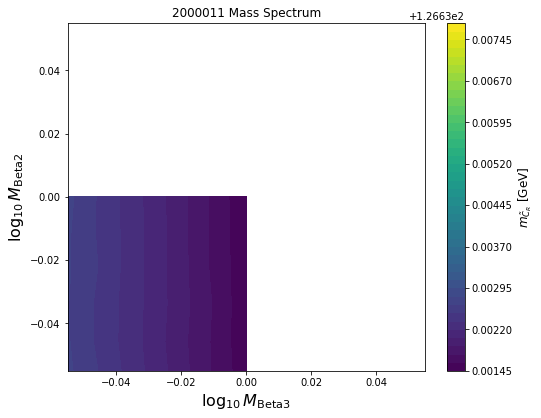

In [12]:
file = resultsFGMCaseB2
plotData, plotData2, plotData3 = [], [], []
for i in gridBeta2:
    row, row2, row3 = [], [], []
    for j in gridBeta3:
        try:
            row.append(file[(j,i)][1].blocks['MASS'][25])
            row2.append(file[(j,i)][1].blocks['MASS'][2000002])
            row3.append(file[(j,i)][1].blocks['MASS'][2000011])
            #row.append(resultsB1mMessLambda40[(j,i)][1].blocks['MINPAR'][1])
        except:
            row.append(0)
            row2.append(0)
            row3.append(0)
            #print((j,i))
    plotData.append(row)
    plotData2.append(row2)
    plotData3.append(row3)
plotData = np.array(plotData)
plotData2 = np.array(plotData2)
plotData3 = np.array(plotData3)
print("plotData is")
#print(plotData)
print("zm, then zn, then z0")
print(Zm)
print("zn")
print(Zn)
print('z0')
print(Zo)

#Zm = np.ma.masked_where(plotData < 1.2, plotData)
#Zn = np.ma.masked_where(plotData2 < 1.2, plotData2)
#Zo = np.ma.masked_where(plotData3 < 1.2, plotData3)
print("zm, then zn, then z0")
print(Zm)
print("zn")
print(Zn)
print('z0')
print(Zo)

fig, ax = plt.subplots( figsize=(8, 6.4))

im = ax.contourf(np.log10(gridBeta3), np.log10(gridBeta2), Zm,50)
plt.xlabel(r'$\log_{10}\, M_{\rm{Beta3}}$',fontsize=16)
plt.ylabel(r'$\log_{10}\,M_{\rm{Beta2}}$',fontsize=16)
cbar = fig.colorbar(im)
cbar.set_label(r'$m_{\tilde C_{R}}$ [GeV]', size=12)
cs = ax.contour(np.log10(gridBeta3), np.log10(gridBeta2), Zm, [124,125,126,127,128],colors='k',linestyles='dotted')
ax.clabel(cs, fontsize=16, inline=1, colors='w',fmt="%1.2f")
#cs = ax.contour(np.log10(gridBeta3), np.log10(gridBeta2), Zn, [12000,12100,12200,12300],colors='k',linestyles='dotted')
#ax.clabel(cs, fontsize=16, inline=1, colors='w',fmt="%1.1f")
#cs = ax.contour(np.log10(gridBeta3), np.log10(gridBeta2), Zo, [4600],colors='k',linestyles='dotted')
#ax.clabel(cs, fontsize=16, inline=1, colors='w',fmt="%1.f")
plt.title("2000011 Mass Spectrum")
plt.savefig("caseb2.pdf")


In [13]:
print(gridBeta2)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]
